In [1]:
import os
os.chdir('..')
os.getcwd()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

In [3]:
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from core.GraphDataBlock import GraphDataBlock
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import evaluate_viz_metrics, trustworthiness, neighborhood_preservation
from util.network_utils import get_net_projection, _get_net_projection
from util.graph_utils import get_shortest_path_matrix, neighbor_sampling

cuda not available


In [4]:
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    print('cuda available')
    device = 'cuda'
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    print('cuda not available')
    device = 'cpu'

cuda not available


In [5]:
dataset_name = 'reddit_test'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(n_batches=1, shuffle=False)
dataset.summarise()

Data blocks of length:  [55334]
Time to create all data (s) = 0.3834
Name of dataset = reddit_test
Input dimension = 602
Number of training samples = 55334
Training labels = True


In [6]:
net_dir = 'reddit_full'
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['L'] = 2 # number of hidden layers

## End of boilerplate code

In [7]:
main_dir = os.path.join('results', net_dir)
main_dir

'results/reddit_full'

In [8]:
# Graph net
def load_net_from_root(root, net_parameters, epoch):
    net_parameters['H'] = 256 # number of hidden units
    net_1 = GraphConvNet(net_parameters)
    if torch.cuda.is_available(): net_1.cuda()
    filename = os.path.join(root, 'graph_net_{}.pkl'.format(epoch))
    checkpoint = torch.load(filename, map_location=device)
    net_1.load_state_dict(checkpoint['state_dict'])
    return net_1

In [13]:
def plot_and_evaluate(y_pred, dataset, ax):
    plot_graph_embedding(y_pred, dataset.labels, dataset.adj_matrix, line_alpha=0.03, s=3, ax=ax)
    evaluate_viz_metrics(y_pred, dataset)
    print('')

In [14]:
sampled_block = dataset.get_sample_block(n_initial=50, sample_neighbors=True, verbose=1)

Initial set of 50 points was expanded to 4963 points


One NN accuracy = 0.2436
Avg graph distance = 1.7445
Avg feature distance = 0.5464
Total distance = 2.2909

One NN accuracy = 0.7524
Avg graph distance = 0.3581
Avg feature distance = 1.0986
Total distance = 1.4566

One NN accuracy = 0.8033
Avg graph distance = 0.2843
Avg feature distance = 1.3287
Total distance = 1.6130



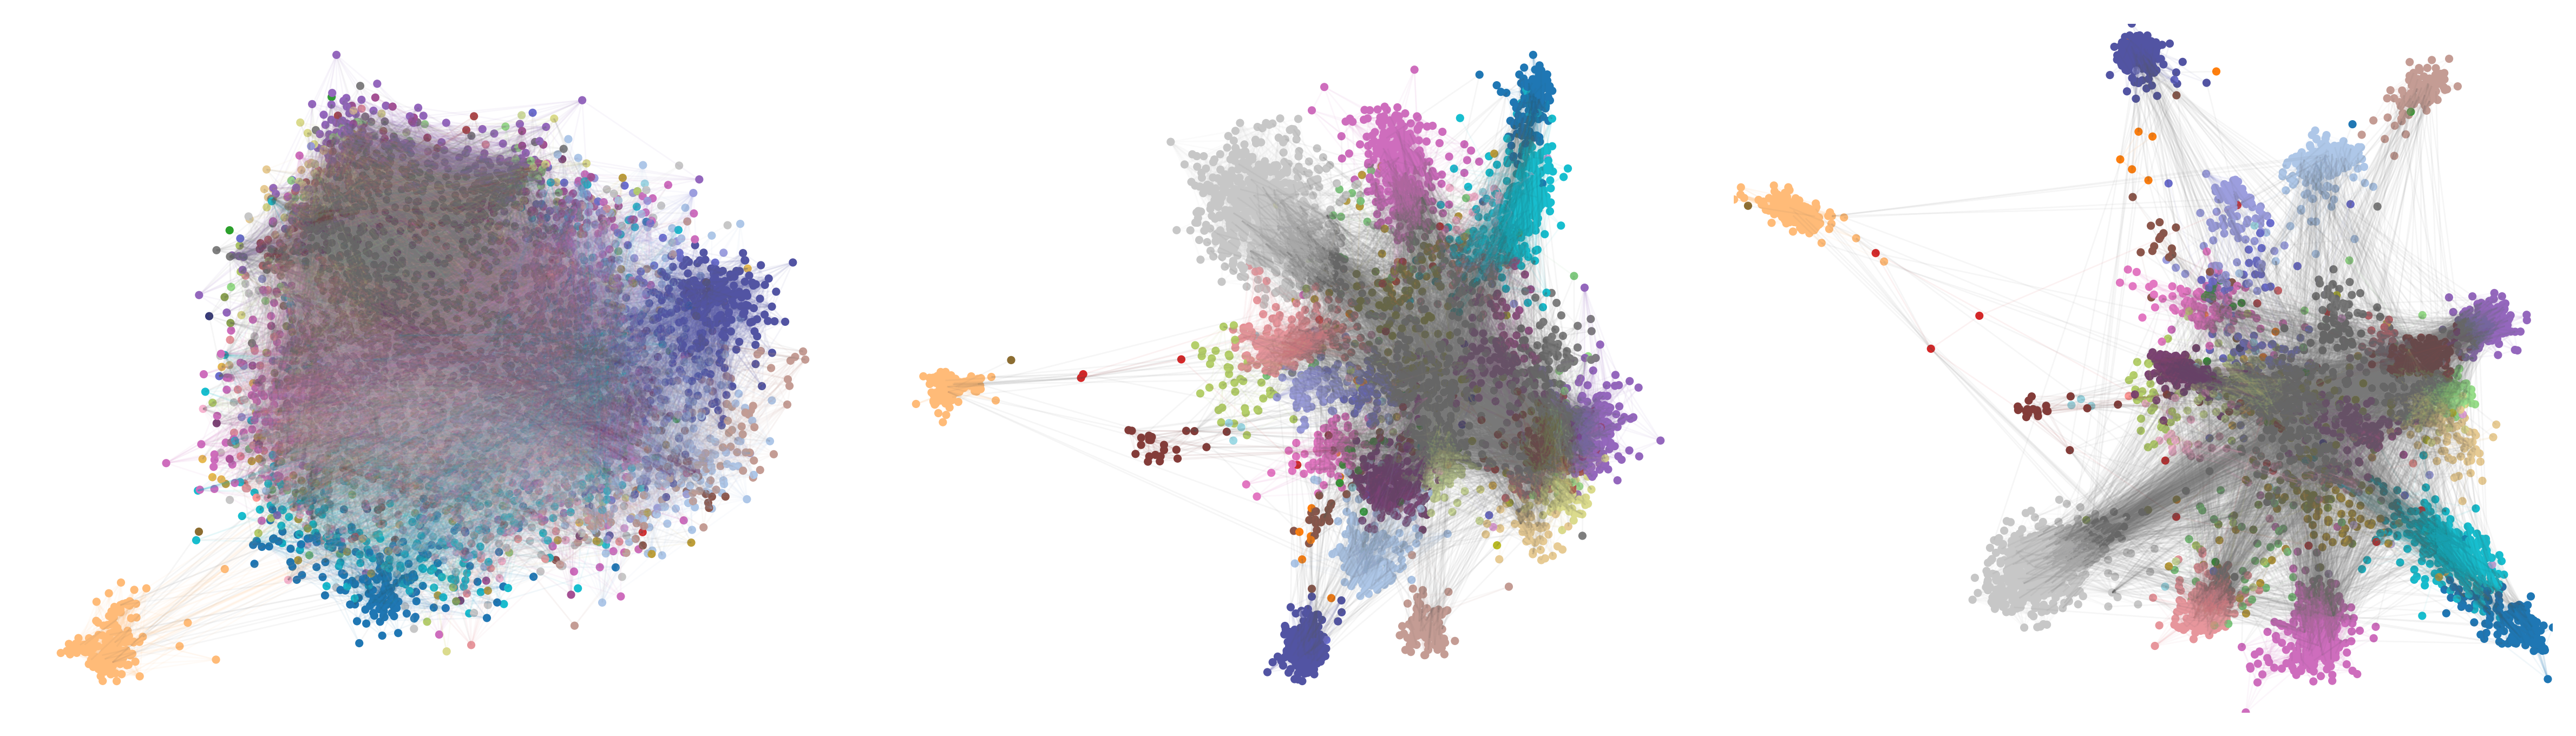

In [15]:
test_range = [1, 6, 11]

f, axarr = plt.subplots(1, 3, figsize=(12, 3.5), dpi=400)
y_outputs = []
for j, r in enumerate(test_range):
    root = os.path.join(main_dir, net_dir) + '_' + str(r)
    net = load_net_from_root(root, net_parameters, epoch=4)
    y_pred = _get_net_projection(net, sampled_block)
    plot_and_evaluate(y_pred, sampled_block, axarr[j])
    axarr[j].set_rasterized(True)
    
    y_outputs.append(y_pred)

plt.tight_layout()

In [16]:
with open('data/{}_plots.pkl'.format(dataset_name), 'wb') as f:
    pickle.dump([y_outputs, sampled_block], f)